## 沪深300股指的预测分类/回归模型
任务一：
参考下面链接，通过至少两种模型判断不同feature的重要性：
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

目前只找到随机森林有特征重要性，其他几个线性回归模型没有。

任务二：
验证不同模型预测沪深300股指的准确性

In [130]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import pandas_datareader.data as web
import FeatureUtils as fu
import datetime
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC,SVC

from sklearn import preprocessing
from sklearn import utils

In [91]:
# 构建包含10个以上feature的序列
def create_series(symbol,start_date,end_date):
    data = web.get_data_yahoo(symbol,start=start_date,end=end_date)
    data = data.dropna(axis=0,how='any')
    #选择如下Features
    data = fu.SMA(data,5)
    data = fu.EMA(data,5)
    data = fu.SMA(data,20)
    data = fu.EMA(data,20)
    data = fu.ATR(data,14)
    data = fu.ADL(data)
    data = fu.CCI(data,20)
    data = fu.ROC(data,14)
    data = fu.PMO(data)
    data = fu.DPO(data,14)
    data = fu.ForceIndex(data)
    data = fu.MassIndex(data)
    data = fu.MACD(data)
    data = fu.RSI(data)
    data = fu.UlcerIndex(data)
    return data
data  = create_series('000300.ss','1/1/2010','1/1/2016')
data.tail(30)

,Open,High,Low,Close,Adj Close,Volume,5_SMA,5_EMA,20_SMA,20_EMA,...,PMO Signal Line,DPO,13-Period FI,Mass Index,MACD,Signal Line,MACD Histogram,RS,14-day RSI,Ulcer Index
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-20,3774.379883,3774.379883,3774.379883,3774.379883,3774.379883,0.0,3757.489942,3763.486789,3684.001489,3689.676744,...,2.086145,88.267142,0.0,0.160154,77.761112,80.918969,-3.157858,-2.936159,151.648658,1.791146
2015-11-23,3753.330078,3753.330078,3753.330078,3753.330078,3753.330078,0.0,3755.329981,3760.101218,3692.204993,3695.738967,...,2.142905,68.117048,0.0,0.155376,73.274895,79.390155,-6.115259,-2.747560,157.222647,1.636152
2015-11-24,3753.889893,3753.889893,3753.889893,3753.889893,3753.889893,0.0,3754.429981,3758.030777,3700.255493,3701.277150,...,2.181787,20.833653,0.0,0.150820,68.969670,77.306058,-8.336388,-1.761035,231.400008,1.743284
2015-11-25,3781.610107,3781.610107,3781.610107,3781.610107,3781.610107,0.0,3767.635986,3765.890553,3713.090002,3708.927908,...,2.211978,-33.649292,0.0,0.146476,67.021949,75.249236,-8.227287,-1.459233,317.754392,1.790572
2015-11-26,3759.429932,3759.429932,3759.429932,3759.429932,3759.429932,0.0,3764.527979,3763.737013,3724.395996,3713.737624,...,2.227393,-13.335100,0.0,0.142331,62.962816,72.791952,-9.829136,-0.818395,-450.644886,1.877041
2015-11-27,3556.989990,3556.989990,3556.989990,3556.989990,3556.989990,0.0,3721.050000,3694.821339,3725.541492,3698.809278,...,2.178058,1.164917,0.0,0.138375,42.916003,66.816762,-23.900759,-0.272185,-37.397546,2.691329
2015-11-30,3566.409912,3566.409912,3566.409912,3566.409912,3566.409912,0.0,3683.665967,3652.017530,3730.063989,3686.199815,...,2.085424,-22.585606,0.0,0.134599,27.472187,58.947847,-31.475661,-0.301893,-43.244618,3.272884
2015-12-01,3591.699951,3591.699951,3591.699951,3591.699951,3591.699951,0.0,3651.227978,3631.911670,3736.374487,3677.199828,...,1.970187,54.086426,0.0,0.130993,17.076696,50.573617,-33.496921,-0.366987,-57.974707,3.572893
2015-12-02,3721.959961,3721.959961,3721.959961,3721.959961,3721.959961,0.0,3639.297949,3661.927767,3741.045483,3681.462698,...,1.875688,58.736346,0.0,0.127548,19.128586,44.284611,-25.156025,-0.786676,-368.769618,3.584003


In [92]:
# 构建分类数据集
def make_classification(data):
    data['pct_change'] = data['Adj Close'].pct_change()*100
    # 如果当跌幅在0.0001%内，进行处理，这样保证最终的Direction只有+1和-1    
    func = lambda x: x if abs(x)>0.0001 else 0.0001
    data['pct_change'] = data['pct_change'].apply(func)
    data['Direction'] = np.sign(data['pct_change'])
    return data
classification_dataset = make_classification(data)
# 去空
classification_dataset = classification_dataset.dropna(axis=0,how='any')
classification_dataset.head()

,Open,High,Low,Close,Adj Close,Volume,5_SMA,5_EMA,20_SMA,20_EMA,...,13-Period FI,Mass Index,MACD,Signal Line,MACD Histogram,RS,14-day RSI,Ulcer Index,pct_change,Direction
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,2345.739990,2345.739990,2298.750000,2298.750000,2298.750000,0.0,2313.762012,2319.547721,2390.331994,2389.560666,...,0.0,0.395019,-68.984474,-70.005462,1.020988,-0.471964,-89.381126,7.574947,-2.003205,-1.0
2012-01-30,2504.090088,2504.090088,2460.719971,2460.719971,2460.719971,0.0,2463.190039,2457.353731,2378.667017,2416.149094,...,0.0,0.802715,5.480620,-15.974552,21.455172,-1.454771,319.890945,2.467792,-1.731971,-1.0
2012-04-05,2454.899902,2512.830078,2454.899902,2512.830078,2512.830078,0.0,2486.577978,2496.111977,2580.053003,2553.110493,...,0.0,0.560359,-25.786599,-7.225678,-18.560921,-0.416340,-71.332630,5.112245,2.359778,1.0
2012-05-02,2626.159912,2683.489990,2626.159912,2683.489990,2683.489990,0.0,2634.400000,2640.908844,2566.666003,2595.468317,...,0.0,0.824278,22.811643,10.630763,12.180880,-3.347964,142.590098,0.886664,2.183038,1.0
2012-06-25,2512.189941,2512.189941,2456.520020,2456.520020,2456.520020,0.0,2532.230029,2515.417553,2569.166003,2558.983595,...,0.0,0.624717,-23.913445,-15.993981,-7.919464,-0.481461,-92.849404,3.537805,-2.215992,-1.0


In [93]:
# 构建回归数据集
def make_regression(data):
    data['Target'] = data['Adj Close'].shift()
    return data
regression_dataset = make_regression(data)
# 去空
regression_dataset = regression_dataset.dropna(axis=0,how='any')
regression_dataset.head()

,Open,High,Low,Close,Adj Close,Volume,5_SMA,5_EMA,20_SMA,20_EMA,...,Mass Index,MACD,Signal Line,MACD Histogram,RS,14-day RSI,Ulcer Index,pct_change,Direction,Target
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,2345.739990,2345.739990,2298.750000,2298.750000,2298.750000,0.0,2313.762012,2319.547721,2390.331994,2389.560666,...,0.395019,-68.984474,-70.005462,1.020988,-0.471964,-89.381126,7.574947,-2.003205,-1.0,2345.739990
2012-01-30,2504.090088,2504.090088,2460.719971,2460.719971,2460.719971,0.0,2463.190039,2457.353731,2378.667017,2416.149094,...,0.802715,5.480620,-15.974552,21.455172,-1.454771,319.890945,2.467792,-1.731971,-1.0,2504.090088
2012-04-05,2454.899902,2512.830078,2454.899902,2512.830078,2512.830078,0.0,2486.577978,2496.111977,2580.053003,2553.110493,...,0.560359,-25.786599,-7.225678,-18.560921,-0.416340,-71.332630,5.112245,2.359778,1.0,2454.899902
2012-05-02,2626.159912,2683.489990,2626.159912,2683.489990,2683.489990,0.0,2634.400000,2640.908844,2566.666003,2595.468317,...,0.824278,22.811643,10.630763,12.180880,-3.347964,142.590098,0.886664,2.183038,1.0,2626.159912
2012-06-25,2512.189941,2512.189941,2456.520020,2456.520020,2456.520020,0.0,2532.230029,2515.417553,2569.166003,2558.983595,...,0.624717,-23.913445,-15.993981,-7.919464,-0.481461,-92.849404,3.537805,-2.215992,-1.0,2512.189941


In [94]:
# 创建数据集合训练集
X_classification = classification_dataset[['5_SMA','5_EMA','20_SMA','20_EMA','ATR','Accu-Dist Line','CCI',\
                                           '14-day ROC','PMO Line','DPO','MACD','14-day RSI','Ulcer Index']]
y_classification = classification_dataset['Direction']

X_regression = regression_dataset[['5_SMA','5_EMA','20_SMA','20_EMA','ATR','Accu-Dist Line','CCI',\
                                           '14-day ROC','PMO Line','DPO','MACD','14-day RSI','Ulcer Index']]
y_regression = regression_dataset['Target']

In [95]:
# 测试数据集以日期分隔
start_test = datetime.datetime(2015,1,1)
X_classification_train = X_classification[X_classification.index < start_test]
X_classification_test = X_classification[X_classification.index >= start_test]
y_classification_train = y_classification[y_classification.index < start_test]
y_classification_test = y_classification[y_classification.index >= start_test]

X_regression_train = X_regression[X_regression.index < start_test]
X_regression_test = X_regression[X_regression.index >= start_test]
y_regression_train = y_regression[y_regression.index < start_test]
y_regression_test = y_regression[y_regression.index >= start_test]

In [96]:
# 构建sk-learn的回归/分类模型
classify_forest = RandomForestClassifier(n_estimators=1000)
regress_forest = RandomForestRegressor(n_estimators=1000)
# 以下模型无法查看特征重要性
lr = LogisticRegression() 
lsvc = LinearSVC()
svc = SVC()

In [126]:
# 分别用各种模型进行训练，然后求出各特征重要性
# 随机森林分类模型
classify_forest.fit(X_classification_train,y_classification_train)
importances = classify_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in classify_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print 'Feature ranking:'
for f in range(X_classification_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 7 (0.135124)
2. feature 8 (0.131342)
3. feature 9 (0.092630)
4. feature 11 (0.083602)
5. feature 12 (0.077299)
6. feature 6 (0.074696)
7. feature 10 (0.074565)
8. feature 0 (0.069337)
9. feature 1 (0.064637)
10. feature 4 (0.059371)
11. feature 2 (0.057210)
12. feature 3 (0.053185)
13. feature 5 (0.000000)


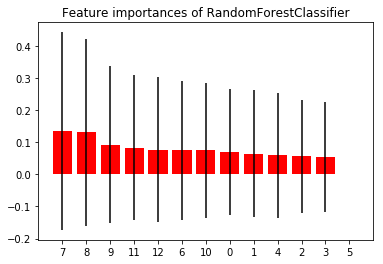

In [127]:
# Plot the feature importances
plt.figure()
plt.title('Feature importances of RandomForestClassifier')
plt.bar(range(X_classification_train.shape[1]),importances[indices],color="r",yerr=std[indices],align="center")
plt.xticks(range(X_classification_train.shape[1]),indices)
plt.xlim([-1,X_classification_train.shape[1]])
plt.show()

In [128]:
# 随机森林回归模型
regress_forest.fit(X_regression_train,y_regression_train)
importances = regress_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in regress_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print 'Feature ranking:'
for f in range(X_regression_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.168986)
2. feature 1 (0.157726)
3. feature 8 (0.124898)
4. feature 3 (0.112595)
5. feature 12 (0.102214)
6. feature 10 (0.073932)
7. feature 2 (0.067171)
8. feature 11 (0.058367)
9. feature 4 (0.056714)
10. feature 7 (0.047593)
11. feature 6 (0.016223)
12. feature 9 (0.013581)
13. feature 5 (0.000000)


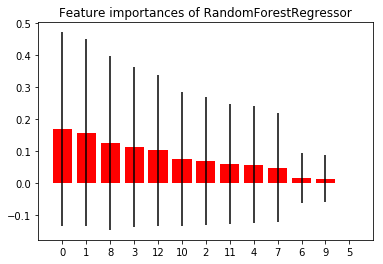

In [129]:
# Plot the feature importances
plt.figure()
plt.title('Feature importances of RandomForestRegressor')
plt.bar(range(X_regression_train.shape[1]),importances[indices],color="r",yerr=std[indices],align="center")
plt.xticks(range(X_regression_train.shape[1]),indices)
plt.xlim([-1,X_regression_train.shape[1]])
plt.show()